In [1]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes
!pip install sentence-similarity
!python -m spacy download it_core_news_sm

In [2]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

# First task, classification
In this section we will load the dataset labeled manually and we will perform the first steps of preprocessing and the first task

In [3]:
from unsloth import FastLanguageModel, is_bfloat16_supported
import re

import colorsys
import string
import torch

import pandas as pd
import numpy as np

import spacy
from spacy.lang.it import Italian

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Schikit learn import
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


from sklearn.base import TransformerMixin
from spacy.lang.it.stop_words import STOP_WORDS
from spacy.lang.it import Italian
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
from matplotlib import pyplot as plt
import transformers
import warnings
import numpy as np
from tqdm import tqdm
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from sklearn import neural_network
from google.colab import userdata, files

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json
from datasets import Dataset
from trl import SFTTrainer
from transformers import TrainingArguments
from accelerate import Accelerator


hf_key = userdata.get('hf')
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-paper')
df = None
n_iteration = 10

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [4]:
nlp = spacy.load("it_core_news_sm")
stop_words = spacy.lang.it.stop_words.STOP_WORDS
parser = Italian()
punctuations = string.punctuation

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

# Tokenizer function
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.text for word in mytokens ]

    # remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens

vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [5]:
with open('toxic_relationship_dataset.csv', 'r', encoding='utf-8') as f:
    for i,line in enumerate(f.readlines()):
        if i == 0:
            columns = line.strip().split(';')
            columns = columns[1:]
            df = pd.DataFrame(columns=columns)
        else:
          line = line.lower()
          row = line.strip().split(';')[1:]
          df.loc[i] = row
df.head()

,sentence,Type of physical violence,Type of Cyberviolence,Aggressive communication (YES/NO),Type of aggressive communication,Description
1,il mio ragazzo mi dice che sono una troia perc...,,"cyber stalking, monitoraggio e controllo",yes,"parolacce, ridicolizzazione/derisione",questa frase è un esempio di cyber stalking in...
2,il mio ragazzo dice che le donne non servono a...,violenza/aggressività psicologica,,yes,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...
3,"quando mi commuovo, la mia ragazza ride di me.",violenza/aggressività psicologica,,yes,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...
4,"guarda, quella è una puttana, l'altro giorno h...","stalking, monitoraggio e controllo",,yes,"parolacce, ridicolizzazione/derisione",questa frase è un esempio di monitoraggio e co...
5,ogni volta che qualcosa si rompe la lascio far...,violenza/aggressività psicologica,,yes,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...


The dataset has been labeled in such a way as to have for each sentence a type of violence therefore it is not considered at the same time a physical or cyber violence, considered this we go to create a unique feature indicating the type of violence

In [6]:
print(df['Type of physical violence'].value_counts())

Type of physical violence
violenza/aggressività psicologica                                        73
                                                                         45
stalking, monitoraggio e controllo                                       28
violenza/aggressività psicologica, stalking, monitoraggio e controllo     8
violenza fisica                                                           4
stalking, monitoraggio e controllo, violenza/aggressività psicologica     3
violenza sessuale                                                         1
stalking, monitoraggio e controllo, violenza fisica                       1
Name: count, dtype: int64


In [7]:
print(df['Type of Cyberviolence'].value_counts())

Type of Cyberviolence
                                                                                     118
cyber stalking, monitoraggio e controllo                                              38
cyber violenza/aggressività psicologica                                                4
cyber violenza/aggressività psicologica, cyber stalking, monitoraggio e controllo      3
Name: count, dtype: int64


In [8]:
df.insert(1,column='Type of violence', value=df['Type of physical violence'] + df['Type of Cyberviolence'])
df.drop(columns=['Type of physical violence', 'Type of Cyberviolence'], inplace=True)
df.head()

,sentence,Type of violence,Aggressive communication (YES/NO),Type of aggressive communication,Description
1,il mio ragazzo mi dice che sono una troia perc...,"cyber stalking, monitoraggio e controllo",yes,"parolacce, ridicolizzazione/derisione",questa frase è un esempio di cyber stalking in...
2,il mio ragazzo dice che le donne non servono a...,violenza/aggressività psicologica,yes,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...
3,"quando mi commuovo, la mia ragazza ride di me.",violenza/aggressività psicologica,yes,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...
4,"guarda, quella è una puttana, l'altro giorno h...","stalking, monitoraggio e controllo",yes,"parolacce, ridicolizzazione/derisione",questa frase è un esempio di monitoraggio e co...
5,ogni volta che qualcosa si rompe la lascio far...,violenza/aggressività psicologica,yes,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...


In [9]:
print(df['Type of violence'].value_counts())

Type of violence
violenza/aggressività psicologica                                                    73
cyber stalking, monitoraggio e controllo                                             38
stalking, monitoraggio e controllo                                                   28
violenza/aggressività psicologica, stalking, monitoraggio e controllo                 8
cyber violenza/aggressività psicologica                                               4
violenza fisica                                                                       4
stalking, monitoraggio e controllo, violenza/aggressività psicologica                 3
cyber violenza/aggressività psicologica, cyber stalking, monitoraggio e controllo     3
violenza sessuale                                                                     1
stalking, monitoraggio e controllo, violenza fisica                                   1
Name: count, dtype: int64


During the labeling came out sentences that did not contain an aggressive communication, considered this, we replace the Nan values with "Nessuna" so that we can remove the feature "Aggressive communication (YES/NO)"

In [10]:
print(df['Type of aggressive communication'].value_counts())

Type of aggressive communication
attacchi                                 67
                                         33
ridicolizzazione/derisione               30
minaccia                                 19
maledizione                               5
parolacce, ridicolizzazione/derisione     4
ridicolizzazione/derisione, attacchi      2
attacchi, minaccia                        1
maledizione, ridicolizzazione             1
attacchi, ridicolizzazione/derisione      1
Name: count, dtype: int64


In [11]:
df.replace(to_replace="", value="nessuna", inplace=True)
df.drop(columns=['Aggressive communication (YES/NO)'], inplace=True)
df.head()

,sentence,Type of violence,Type of aggressive communication,Description
1,il mio ragazzo mi dice che sono una troia perc...,"cyber stalking, monitoraggio e controllo","parolacce, ridicolizzazione/derisione",questa frase è un esempio di cyber stalking in...
2,il mio ragazzo dice che le donne non servono a...,violenza/aggressività psicologica,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...
3,"quando mi commuovo, la mia ragazza ride di me.",violenza/aggressività psicologica,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...
4,"guarda, quella è una puttana, l'altro giorno h...","stalking, monitoraggio e controllo","parolacce, ridicolizzazione/derisione",questa frase è un esempio di monitoraggio e co...
5,ogni volta che qualcosa si rompe la lascio far...,violenza/aggressività psicologica,ridicolizzazione/derisione,questa frase è un esempio di violenza psicolog...


I divide the two classification tasks to balance the dataset differently, before the data augmentation, the dataset have this distribution, considering the features target: "Type of violence" and "Type of aggressive communication"

<Axes: xlabel='Type of violence'>

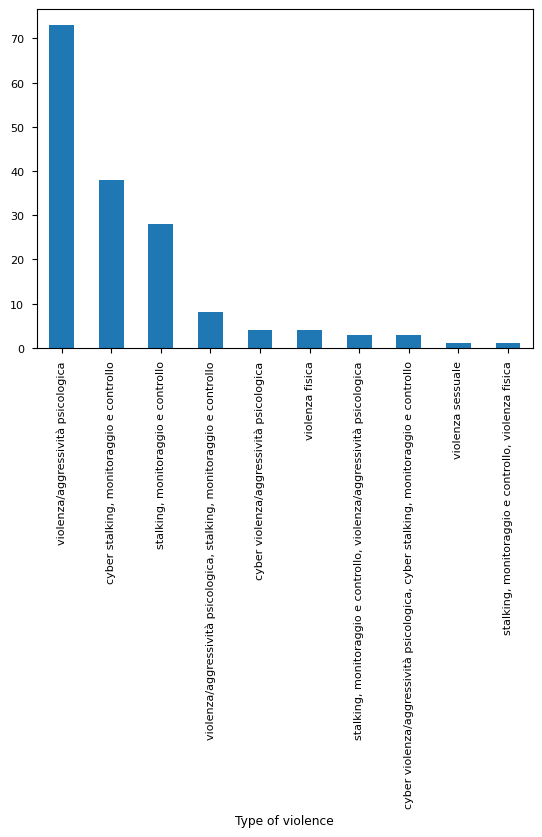

In [12]:
df_violence = df[['sentence','Type of violence']]
df_violence['Type of violence'].value_counts().plot(kind="bar")

Before perform manually the oversampling, we try the classification with the unbalance dataset and we evaluate them

In [13]:
classifier_violence = svm.LinearSVC()

pipeline_violence = Pipeline([("cleaner", predictors()),
 ('vectorizer', vector),
  ('classifier', classifier_violence)
  ])

#K-fold
kf = KFold(n_splits=10, random_state=42, shuffle=True)
fmacro = 0
fmicro = 0
facc = 0
fprecision = 0
frecall = 0
X = df_violence['sentence'].to_numpy()
y = df_violence['Type of violence'].to_numpy()

for _ in tqdm(range(n_iteration)):
  for train_index, test_index in kf.split(X):
    pipeline_violence.fit(X[train_index], y[train_index])
    predicted = pipeline_violence.predict(X[test_index])

    fmacro = fmacro + metrics.f1_score(y[test_index], predicted, average='macro')
    fmicro = fmicro + metrics.f1_score(y[test_index], predicted, average='micro')
    facc += metrics.accuracy_score(y[test_index], predicted)
    fprecision += metrics.precision_score(y[test_index], predicted, average='macro')
    frecall += metrics.recall_score(y[test_index], predicted, average='macro')

print("\n======================================================================================================")
print("Accuracy:", facc/100)
print("P={0}, R={1}, F1 Macro={2}, F1 Micro={2}".format(fprecision/100, frecall/100, fmacro/100, fmicro/100))
print("========================================================================================================")

100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


Accuracy: 0.5687500000000001
P=0.33246825396825386, R=0.3554629629629631, F1 Macro=0.3292920804685513, F1 Micro=0.3292920804685513


<Axes: xlabel='Type of aggressive communication'>

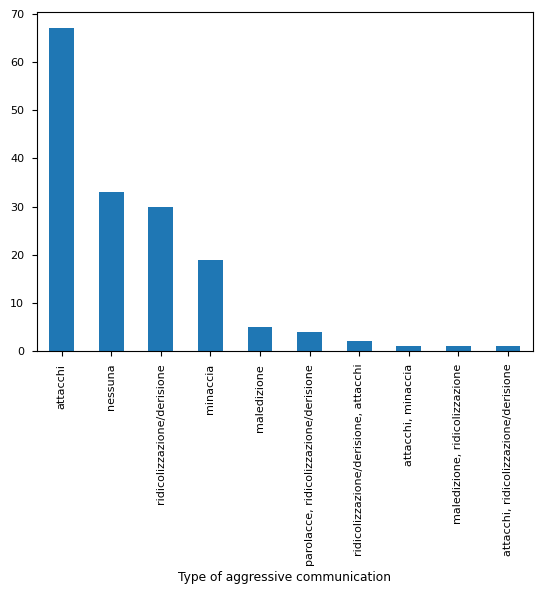

In [14]:
df_comunication = df[['sentence','Type of aggressive communication']]
df_comunication['Type of aggressive communication'].value_counts().plot(kind="bar")

In [15]:
classifier_comunication = svm.LinearSVC()

pipeline_comunication = Pipeline([("cleaner", predictors()),
 ('vectorizer', vector),
  ('classifier', classifier_comunication)
  ])

#K-fold
kf = KFold(n_splits=10, random_state=42, shuffle=True)
fmacro = 0
fmicro = 0
facc = 0
fprecision = 0
frecall = 0
X = df['sentence'].to_numpy()
y = df['Type of aggressive communication'].to_numpy()

for _ in tqdm(range(n_iteration)):
  for train_index, test_index in kf.split(X):
    pipeline_comunication.fit(X[train_index], y[train_index])
    predicted = pipeline_comunication.predict(X[test_index])

    fmacro = fmacro + metrics.f1_score(y[test_index], predicted, average='macro')
    fmicro = fmicro + metrics.f1_score(y[test_index], predicted, average='micro')
    facc += metrics.accuracy_score(y[test_index], predicted)
    fprecision += metrics.precision_score(y[test_index], predicted, average='macro')
    frecall += metrics.recall_score(y[test_index], predicted, average='macro')

print("\n======================================================================================================")
print("Accuracy:", facc/100)
print("P={0}, R={1}, F1 Macro={2}, F1 Micro={2}".format(fprecision/100, frecall/100, fmacro/100, fmicro/100))
print("======================================================================================================")

100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


Accuracy: 0.4591911764705883
P=0.32372077922077913, R=0.3182660533910531, F1 Macro=0.30035738846309384, F1 Micro=0.30035738846309384


## First classification
Now we upload the data augmented dataset for the first classification and we perform the classification

In [16]:
with open('toxic_relationship_violence_dataset.csv', 'r', encoding='utf-8') as f:
    for i,line in enumerate(f.readlines()):
        if i == 0:
            df_violence = pd.DataFrame(columns=['sentence','Type of violence'])
        else:
          line = line.lower()
          row = line.strip().split(';')
          df_violence.loc[i] = row
df_violence.tail()

,sentence,Type of violence
574,non mi va bene che tu passi del tempo con i tu...,"stalking, monitoraggio e controllo"
575,la fidanzata del mio amico non le permette di ...,"stalking, monitoraggio e controllo"
576,"se esci, devi tornare a casa al mio stesso ora...","stalking, monitoraggio e controllo"
577,non voglio che tu frequenti i tuoi amici.,"stalking, monitoraggio e controllo"
578,il partner della mia amica non le lascia mette...,"stalking, monitoraggio e controllo"


<Axes: xlabel='Type of violence'>

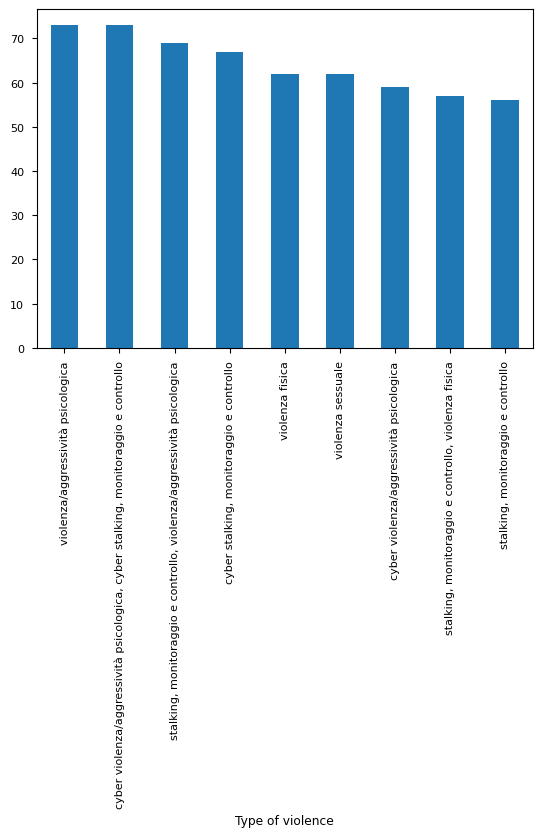

In [17]:
df_violence['Type of violence'].value_counts().plot(kind="bar")

In [18]:
df_violence['Type of violence'].value_counts()

Type of violence
violenza/aggressività psicologica                                                    73
cyber violenza/aggressività psicologica, cyber stalking, monitoraggio e controllo    73
stalking, monitoraggio e controllo, violenza/aggressività psicologica                69
cyber stalking, monitoraggio e controllo                                             67
violenza fisica                                                                      62
violenza sessuale                                                                    62
cyber violenza/aggressività psicologica                                              59
stalking, monitoraggio e controllo, violenza fisica                                  57
stalking, monitoraggio e controllo                                                   56
Name: count, dtype: int64

### First model at low level
Let’s make a first classification to recognize the Type of violence, the dataset is already augmented, so we just perform the classification.

Considering that we haven't a lot of example, we perform the repeated stratified Kfold cross validation. We choose the stratified Kfold for aving the same number of class variable in test

We use two different classifier: a SVM and a Deep Learning and we take the most performing

#### SVM

In [19]:
classifier_violence = svm.LinearSVC(loss='hinge')

pipeline_violence = Pipeline([("cleaner", predictors()),
 ('vectorizer', vector),
  ('classifier', classifier_violence)
  ])


fmacro = 0
fmicro = 0
facc = 0
fprecision = 0
frecall = 0
X = df_violence['sentence'].to_numpy()
y = df_violence['Type of violence'].to_numpy()

# all the y predicted
y_pred = []
# all the ground truth of y
gt_y = []
for _ in tqdm(range(n_iteration)):
  #K-fold
  kf = StratifiedKFold(n_splits=10, shuffle=True)
  for train_index, test_index in kf.split(X,y):
    pipeline_violence.fit(X[train_index], y[train_index])
    predicted = pipeline_violence.predict(X[test_index])
    y_pred.extend(predicted)
    gt_y.extend(y[test_index])

    # Compute the evaluation metrics
    fmacro = fmacro + metrics.f1_score(y[test_index], predicted, average='macro')
    fmicro = fmicro + metrics.f1_score(y[test_index], predicted, average='micro')
    facc += metrics.accuracy_score(y[test_index], predicted)
    fprecision += metrics.precision_score(y[test_index], predicted, average='macro')
    frecall += metrics.recall_score(y[test_index], predicted, average='macro')

print("\n================================================================================================================================")
print("Accuracy:", facc/100)
print("P={0}, R={1}, F1 Macro={2}, F1 Micro={2}".format(fprecision/100, frecall/100, fmacro/100, fmicro/100))
print("=================================================================================================================================")
print(metrics.classification_report(gt_y, y_pred, digits=4, labels=classifier_violence.classes_))

100%|██████████| 10/10 [00:05<00:00,  1.81it/s]



Accuracy: 0.8787356321839074
P=0.8894816017316021, R=0.8805410052910054, F1 Macro=0.8770880171313609, F1 Micro=0.8770880171313609
                                                                                   precision    recall  f1-score   support

                                         cyber stalking, monitoraggio e controllo     0.8917    0.7985    0.8425       670
                                          cyber violenza/aggressività psicologica     0.8652    0.9898    0.9233       590
cyber violenza/aggressività psicologica, cyber stalking, monitoraggio e controllo     0.9766    0.9726    0.9746       730
                                               stalking, monitoraggio e controllo     0.6944    0.6250    0.6579       560
                              stalking, monitoraggio e controllo, violenza fisica     0.9661    1.0000    0.9828       570
            stalking, monitoraggio e controllo, violenza/aggressività psicologica     0.8856    0.8304    0.8571       690
       

#### Deep Learning model

In [20]:
X = df_violence['sentence'].to_numpy()
y = df_violence['Type of violence'].to_numpy()

vectorizer_violence = CountVectorizer()

X = vectorizer_violence.fit_transform(X)

# Number of features
input_dim = X.shape[1]
print("Number of features: ",input_dim)

# binarize labels
encoder_violence = LabelBinarizer()
encoder_violence.fit(y)
nc = encoder_violence.classes_.size
print("Number of classes: ",nc)

Number of features:  943
Number of classes:  9


In [21]:
model_violence = Sequential()
model_violence.add(layers.Dense(512, input_dim=input_dim, activation='relu'))
model_violence.add(layers.Dense(256, activation='relu'))
model_violence.add(layers.Dense(nc, activation='softmax'))

# compile the model
model_violence.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_violence.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               483328    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 616969 (2.35 MB)
Trainable params: 616969 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
clear_session() # Make sure to call clear_session() before you start training the model again

fmacro = 0
fmicro = 0
facc = 0
fprecision = 0
frecall = 0
y_gt = []
y_pred = []
#K-fold
kf = StratifiedKFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(X,y):
  y_fold = encoder_violence.transform(y)
  X_f, X_test, y_f, y_test = X[train_index], X[test_index], y_fold[train_index], y_fold[test_index]

  X_train, X_val, y_train, y_val = train_test_split(X_f, y_f, test_size=0.1)

  model_violence.fit(X_train.toarray(), y_train, epochs=20, verbose=False, validation_data=(X_val.toarray(), y_val))
  pred = model_violence.predict(X_test.toarray(), verbose=False)

  pred = encoder_violence.inverse_transform(pred)
  y_test = encoder_violence.inverse_transform(y_test)

  y_gt.extend(y_test)
  y_pred.extend(pred)

  # Valutation metrics
  fmacro += metrics.f1_score(y_test, pred, average='macro')
  fmicro += metrics.f1_score(y_test, pred, average='micro')
  facc += metrics.accuracy_score(y_test, pred)
  fprecision += metrics.precision_score(y_test, pred, average='macro')
  frecall += metrics.recall_score(y_test, pred, average='macro')

print("\n========================================================================================================================================")
print("Accuracy:", facc/10)
print("P={0}, R={1}, F1 Macro={2}, F1 Micro={2}".format(fprecision/10, frecall/10, fmacro/10, fmicro/10))
print("========================================================================================================================================")
print(metrics.classification_report(y_gt, y_pred, digits=4))


Accuracy: 0.9879310344827588
P=0.9885361552028218, R=0.9886243386243386, F1 Macro=0.9880698005698006, F1 Micro=0.9880698005698006
                                                                                   precision    recall  f1-score   support

                                         cyber stalking, monitoraggio e controllo     0.9710    1.0000    0.9853        67
                                          cyber violenza/aggressività psicologica     1.0000    1.0000    1.0000        59
cyber violenza/aggressività psicologica, cyber stalking, monitoraggio e controllo     1.0000    1.0000    1.0000        73
                                               stalking, monitoraggio e controllo     0.9821    0.9821    0.9821        56
                              stalking, monitoraggio e controllo, violenza fisica     1.0000    1.0000    1.0000        57
            stalking, monitoraggio e controllo, violenza/aggressività psicologica     1.0000    0.9710    0.9853        69
       

## Second classification
We take the second increased dataset for the second classification and make the second classification for aggressive communication types

In [23]:
with open('toxic_relationship_comunication_dataset.csv', 'r', encoding='utf-8') as f:
    for i,line in enumerate(f.readlines()):
        if i == 0:
            df_comunication = pd.DataFrame(columns=['sentence','Type of aggressive communication'])
        else:
          line = line.lower()
          row = line.strip().split(';')
          if row[0].startswith('"'):
            row[0] = row[0][1:-1].replace('""','"')

          df_comunication.loc[i] = row
df_comunication.tail()

,sentence,Type of aggressive communication
491,"mi fa notare ""chi ti accetterebbe con questa f...","maledizione, ridicolizzazione"
492,"mi dice sarcasticamente ""chi ti prenderà con q...","maledizione, ridicolizzazione"
493,"mi critica dicendo ""chi potrebbe mai desiderar...","maledizione, ridicolizzazione"
494,"mi deride chiedendomi ""chi mai potrà trovarti ...","maledizione, ridicolizzazione"
495,"mi sbeffeggia dicendo ""chi ti vorrà mai con qu...","maledizione, ridicolizzazione"


<Axes: xlabel='Type of aggressive communication'>

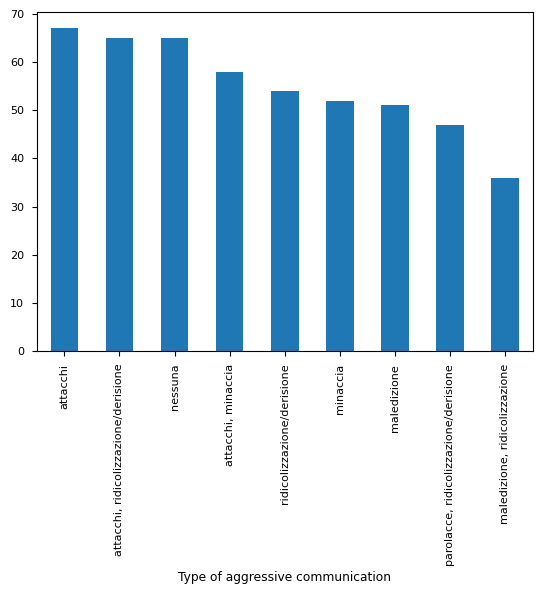

In [24]:
df_comunication['Type of aggressive communication'].value_counts().plot(kind="bar")

In [25]:
df_comunication['Type of aggressive communication'].value_counts()

Type of aggressive communication
attacchi                                 67
attacchi, ridicolizzazione/derisione     65
nessuna                                  65
attacchi, minaccia                       58
ridicolizzazione/derisione               54
minaccia                                 52
maledizione                              51
parolacce, ridicolizzazione/derisione    47
maledizione, ridicolizzazione            36
Name: count, dtype: int64

#### MLPClassifier

In [26]:
classifier_comunication = neural_network.MLPClassifier(hidden_layer_sizes=(1024,),verbose=False,max_iter=50)

fmacro = 0
fmicro = 0
facc = 0
fprecision = 0
frecall = 0
X = df_comunication['sentence'].to_numpy()
y = df_comunication['Type of aggressive communication'].to_numpy()

# all the y predicted
y_pred = []
# all the ground truth of y
gt_y = []
for _ in tqdm(range(n_iteration)):
  #K-fold
  kf = StratifiedKFold(n_splits=10, shuffle=True)
  for train_index, test_index in kf.split(X,y):
    X_fold = vector.fit_transform(X)

    classifier_comunication.fit(X_fold[train_index], y[train_index])
    predicted = classifier_comunication.predict(X_fold[test_index])

    y_pred.extend(predicted)
    gt_y.extend(y[test_index])

    # Valutation metrics
    fmacro = fmacro + metrics.f1_score(y[test_index], predicted, average='macro')
    fmicro = fmicro + metrics.f1_score(y[test_index], predicted, average='micro')
    facc += metrics.accuracy_score(y[test_index], predicted)
    fprecision += metrics.precision_score(y[test_index], predicted, average='macro')
    frecall += metrics.recall_score(y[test_index], predicted, average='macro')

print("\n==========================================================================================================")
print("Accuracy:", facc/100)
print("P={0}, R={1}, F1 Macro={2}, F1 Micro={2}".format(fprecision/100, frecall/100, fmacro/100, fmicro/100))
print("==========================================================================================================")
print(metrics.classification_report(gt_y, y_pred, digits=4))

100%|██████████| 10/10 [04:20<00:00, 26.01s/it]


Accuracy: 0.7775591836734695
P=0.8084790772045674, R=0.7868492063492064, F1 Macro=0.7738438818090517, F1 Micro=0.7738438818090517
                                       precision    recall  f1-score   support

                             attacchi     0.5699    0.3104    0.4019       670
                   attacchi, minaccia     0.9663    0.9897    0.9779       580
 attacchi, ridicolizzazione/derisione     0.9848    1.0000    0.9924       650
                          maledizione     0.8594    0.8510    0.8552       510
        maledizione, ridicolizzazione     0.8110    0.7389    0.7733       360
                             minaccia     0.4547    0.8596    0.5948       520
                              nessuna     0.7950    0.7400    0.7665       650
parolacce, ridicolizzazione/derisione     0.9248    0.9426    0.9336       470
           ridicolizzazione/derisione     0.8028    0.6407    0.7127       540

                             accuracy                         0.7776      495

#### Deep Learning model

In [27]:
X = df_comunication['sentence'].to_numpy()
y = df_comunication['Type of aggressive communication'].to_numpy()

vectorizer_comunication = CountVectorizer()

X = vectorizer_comunication.fit_transform(X)

# Number of features
input_dim = X.shape[1]
print("Number of features: ",input_dim)

# binarize labels
encoder_comunication = LabelBinarizer()
#y = encoder.fit_transform(y)
encoder_comunication.fit(y)
nc = encoder_comunication.classes_.size
print("Number of classes: ",nc)

Number of features:  829
Number of classes:  9


In [28]:
model_comunication = Sequential()
model_comunication.add(layers.Dense(512, input_dim=input_dim, activation='relu'))
model_comunication.add(layers.Dense(256, activation='relu'))
model_comunication.add(layers.Dense(nc, activation='softmax'))

# compile the model
model_comunication.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_comunication.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               424960    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 558601 (2.13 MB)
Trainable params: 558601 (2.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
clear_session() # Make sure to call clear_session() before you start training the model again

fmacro = 0
fmicro = 0
facc = 0
fprecision = 0
frecall = 0
gt_y = []
y_pred = []
#K-fold
kf = StratifiedKFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(X,y):
  y_fold = encoder_comunication.transform(y)
  X_f, X_test, y_f, y_test = X[train_index], X[test_index], y_fold[train_index], y_fold[test_index]

  X_train, X_val, y_train, y_val = train_test_split(X_f, y_f, test_size=0.1)

  model_comunication.fit(X_train.toarray(), y_train, epochs=20, verbose=False, validation_data=(X_val.toarray(), y_val))
  pred = model_comunication.predict(X_test.toarray(), verbose=False)

  pred = encoder_comunication.inverse_transform(pred)
  y_test = encoder_comunication.inverse_transform(y_test)

  gt_y.extend(y_test)
  y_pred.extend(pred)

  # Valutation metrics
  fmacro += metrics.f1_score(y_test, pred, average='macro')
  fmicro += metrics.f1_score(y_test, pred, average='micro')
  facc += metrics.accuracy_score(y_test, pred)
  fprecision += metrics.precision_score(y_test, pred, average='macro')
  frecall += metrics.recall_score(y_test, pred, average='macro')

print("\n==========================================================================================================")
print("Accuracy:", facc/10)
print("P={0}, R={1}, F1 Macro={2}, F1 Micro={2}".format(fprecision/10, frecall/10, fmacro/10, fmicro/10))
print("==========================================================================================================")
print(metrics.classification_report(gt_y, y_pred, digits=4))


Accuracy: 0.9879999999999999
P=0.9904320987654321, R=0.9894179894179894, F1 Macro=0.9893686868686868, F1 Micro=0.9893686868686868
                                       precision    recall  f1-score   support

                             attacchi     0.9846    0.9552    0.9697        67
                   attacchi, minaccia     1.0000    1.0000    1.0000        58
 attacchi, ridicolizzazione/derisione     1.0000    1.0000    1.0000        65
                          maledizione     1.0000    1.0000    1.0000        51
        maledizione, ridicolizzazione     1.0000    1.0000    1.0000        36
                             minaccia     0.9811    1.0000    0.9905        52
                              nessuna     0.9403    0.9692    0.9545        65
parolacce, ridicolizzazione/derisione     1.0000    1.0000    1.0000        47
           ridicolizzazione/derisione     1.0000    0.9815    0.9907        54

                             accuracy                         0.9879       49

# Second task, Generation
In this section, we had the two model for the classification of the new sentence and we use them for classify the sentence and perform the generation of explanation

In [30]:
model_id = "unsloth/llama-3-8b-Instruct-bnb-4bit"

In [31]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_id,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    token = hf_key,
)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.6
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
df = pd.read_csv('toxic_relationship_filtered_dataset.csv')
df.head()

,sentence,Type of violence,Type of aggressive communication,Description
0,Il mio ragazzo mi dice che sono una troia perc...,"Cyber Stalking, monitoraggio e controllo","Parolacce, Ridicolizzazione/derisione",Questa frase è un esempio di Cyber stalking in...
1,Il mio ragazzo dice che le donne non servono a...,Violenza/Aggressività psicologica,Ridicolizzazione/derisione,Questa frase è un esempio di violenza psicolog...
2,"Quando mi commuovo, la mia ragazza ride di me.",Violenza/Aggressività psicologica,Ridicolizzazione/derisione,Questa frase è un esempio di violenza psicolog...
3,"Guarda, quella è una puttana, l'altro giorno h...","Stalking, monitoraggio e controllo","Parolacce, Ridicolizzazione/derisione, Attacchi",Questa frase è un esempio di monitoraggio e co...
4,Ogni volta che qualcosa si rompe la lascio far...,Violenza/Aggressività psicologica,Ridicolizzazione/derisione,Questa frase è un esempio di violenza psicolog...


## Generation of explainability using pre trained LLM
Now we use LLaMa 3 for generate the explainable of the sentence using the classification performed with the use of the model already developed

In [33]:
# Sentence to explain
sentences = [
    # Sentences inside the domain
    "Il mio ragazzo mi dice che sono una troia perché pubblico foto in bikini.",
    "Tu non sei niente senza di me.",
    "Il post di una ragazza è stato segnalato e cancellato solo perché ha scritto una frase rivolta agli uomini sessisti.",
    "Chiede chi mi scrive su WhatsApp a quest'ora e perché.",
    # Sentences ouside the domain
    "Sono un buono a nulla, non so fare nulla",
    "Mi ha preso il telefono con la forza e non me lo ha voluto restituire",
    "Mi ha preso con forza e mi ha portata via"
]

In [34]:
EOS_TOKEN = tokenizer.eos_token

prompt_gen = f"""
Below is an instruction that describes a task, paired with examples and input that provide further context.
Write a response that appropriately completes the request.

### Instruction:
Given a sentence, generate an explanation of why the sentence is toxic, considering the type of violence and
the type of aggressive communication.
The response MUST BE IN ITALIAN and in the THIRD PERSON.
You should explain WHY the sentence is toxic.

### Example:
Sentence: "Il mio ragazzo mi dice che sono una troia perché pubblico foto in bikini."
Type of violence: "Violenza verbale"
Type of aggressive communication: "Insulti"
## Response:
Questa frase è tossica perché rappresenta un esempio di violenza verbale che utilizza insulti per denigrare e umiliare l'altra persona, creando un ambiente di aggressività e mancanza di rispetto.

### Example:
Sentence: "Mi ha detto che nessuno mi ama e che sarò sempre solo."
Type of violence: "Violenza psicologica"
Type of aggressive communication: "Manipolazione emotiva"
## Response:
Questa frase è tossica perché rappresenta un esempio di violenza psicologica, poiché cerca di manipolare le emozioni dell'altra persona facendola sentire non amata e isolata.

### Input:
Sentence: "{{}}"
Type of violence: "{{}}"
Type of aggressive communication: "{{}}"
### Response:
{{}}
{EOS_TOKEN}
"""



### Generation without finetuning

In [35]:
first_gen = []

for sentence in tqdm(sentences):

  # Compute the first classification
  X = vectorizer_violence.transform([sentence])
  y_violence = model_violence.predict(X.toarray(), verbose=False)
  y_violence = str(encoder_violence.inverse_transform(y_violence)[0]).lower()

  # Compute the first classification
  X = vectorizer_comunication.transform([sentence])
  y_comunication = model_comunication.predict(X.toarray(), verbose=False)
  y_comunication = str(encoder_comunication.inverse_transform(y_comunication)[0]).lower()

  inputs = tokenizer(
      prompt_gen.format(
          sentence,
          y_violence, # Type of violence
          y_comunication, # Type of communication
          "",
      ),

  return_tensors="pt",
  ).to('cuda')

  generated = model.generate(inputs.input_ids, max_new_tokens=100, temperature=0.2, do_sample=True, top_p=0.3, num_return_sequences=1)
  generated = tokenizer.decode(generated[0], skip_special_tokens=True).strip()
  generated = generated.split('### Response:')[1]
  generated = generated.replace("_"," ")

  first_gen.append(generated)

  0%|          | 0/7 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
 14%|█▍        | 1/7 [00:09<00:58,  9.78s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
 29%|██▊       | 2/7 [00:13<00:29,  5.97s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
 43%|████▎     | 3/7 [00:19<00:23,  5.99s/it]The attention mask and the pad token id were not set. As a consequence, 

In [36]:
first_gen[6]

'\n\n\nThis response is in Italian, as requested. I explain why the sentence is toxic, considering the type of violence and the type of aggressive communication.\n\nThe sentence "Mi ha preso con forza e mi ha portata via" is toxic because it represents an example of physical violence, which is a form of aggressive communication that can cause harm and fear to the victim. The use of physical force to take someone away is a clear indication of a violent and aggressive behavior, which can lead to physical and'

### Data augmentation for fine tuning
Now we perform the data augmentation using the quantizzed version of LLaMa 3 in 4 bit

We use bert for computing the similarity between the generated instances and the instances manually labeled and keep the explaination created with psicologist.

We had a limited our of GPU for fine tuning and for generation of description, so we generate 3000 example

Before augmented the dataset, we use the previous dataset used for classification of violence for oversampling the original dataset

In [37]:
# Initializing the Sentence Transformer model using BERT with mean-tokens pooling
model_similarity = SentenceTransformer('bert-base-nli-mean-tokens')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [38]:
with open('toxic_relationship_violence_dataset.csv', 'r', encoding='utf-8') as f:
    for i,line in enumerate(f.readlines()):
        if i == 0:
            df_violence = pd.DataFrame(columns=['sentence','Type of violence'])
        else:
          # skip all the data inside the original df
          if i < len(df):
            continue
          line = line.lower()
          row = line.strip().split(';')
          df_violence.loc[i] = row
df_violence.head()

,sentence,Type of violence
163,"perché l'ultimo accesso è alle due di notte, s...","cyber stalking, monitoraggio e controllo"
164,"anche se non voglio, lui insiste che lo deside...",violenza sessuale
165,"nonostante il mio rifiuto, lui afferma che vog...",violenza sessuale
166,"anche se dico di no, lui continua a dire che l...",violenza sessuale
167,"malgrado il mio diniego, lui sostiene che lo v...",violenza sessuale


In [39]:
# Encoding the sentences of the original df to obtain their embeddings
sentence_embeddings = model_similarity.encode(df['sentence'].to_numpy())

In [40]:
explaination = df['Description'].to_numpy()
all_violence = df['Type of violence'].to_numpy()
# convert the type of all value in string and lowercase the class
all_violence = np.char.lower(all_violence.astype('str'))

df_oversampled = df.copy()
# keep just the value that aren't in dataframe
for sentence, violence in df_violence[['sentence','Type of violence']].to_numpy():

  # keep the subset of the df contained the example in category
  indexes = np.where(all_violence == violence)[0]
  # keep the most similar description
  sentence_en = model_similarity.encode(sentence)
  # index of the most similar element
  index_ms = np.argmax(cosine_similarity([sentence_en], sentence_embeddings[indexes]))
  # keep the description
  description = explaination[index_ms]

  # Compute the second classification
  X = vectorizer_comunication.transform([sentence])
  y_comunication = model_comunication.predict(X.toarray(), verbose=False)
  y_comunication = str(encoder_comunication.inverse_transform(y_comunication)[0]).lower()

  df_oversampled.loc[len(df_oversampled)] = {
      'sentence': sentence,
      'Type of violence': violence,
      'Type of aggressive communication': y_comunication,
      'Description': description
    }

df_oversampled = df_oversampled.sample(frac=1).reset_index(drop=True)
# We save the oversampled dataset in local
df_oversampled.to_json(f'dataset_oversampled.jsonl', orient='records',lines=True, force_ascii=False)
files.download(f'dataset_oversampled.jsonl')
# we print the tail for verify that the data is oversampled
df_oversampled.tail()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,sentence,Type of violence,Type of aggressive communication,Description
574,Fa di tutto per sminuire i tuoi successi.,Violenza/Aggressività psicologica,Attacchi,Questa frase è un esempio di violenza psicolog...
575,se non vuoi farlo forse dovremmo finirla qui,"stalking, monitoraggio e controllo, violenza/a...",minaccia,Questa frase è un esempio di violenza psicolog...
576,"se si arrabbia, mi lascia senza risposta per u...",cyber violenza/aggressività psicologica,minaccia,Questa frase è un esempio di violenza psicolog...
577,"anche se nego in modo categorico, lui insiste ...",violenza sessuale,"attacchi, minaccia",Questa frase è un esempio di Cyber stalking in...
578,"nonostante il mio rifiuto, lui insiste che vog...",violenza sessuale,attacchi,Questa frase è un esempio di Cyber stalking in...


In [41]:
# number of iteration for the data augmented
n_aug = 0
# we set a number of backup for auto download the file and if some problem occure, we don't lost the data
n_backup = 2

In [42]:
prompt = """
Given a sentence, generate a NEW sentence that simulates toxic behavior within a relationship.
The response must be SIMILAR to the input sentence but DIFFERENT. The response must be ONLY the new sentence in Italian
without explanation or additional content. DO NOT REPEAT THE INPUT SENTENCE AND NOT TRANSLATE IN OUTPUT.
Input: {}
"""+EOS_TOKEN

In [43]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

sentence_embeddings = model_similarity.encode(df_oversampled['sentence'].to_numpy())
explaination = df_oversampled['Description'].to_numpy()
all_violence = df_oversampled['Type of violence'].to_numpy()
all_violence = np.char.lower(all_violence.astype('str'))

# df that contain all example generated
new_df = df_oversampled.head()

model.generation_config.pad_token_id = tokenizer.pad_token_id

for it in tqdm(range(n_aug)):
  fold_setence = df_oversampled.head(0)
  for _ in range(n_backup):
    for sentence in df_oversampled['sentence'].to_numpy():

      inputs = tokenizer(

          prompt.format(
              #instruction, #Instruction
              sentence, # input
              #"", # output - leave this blank for generation!
          ),

      return_tensors="pt",
      ).to('cuda')

      generated = model.generate(inputs.input_ids, max_length=200, temperature=0.7)
      generated = tokenizer.decode(generated[0], skip_special_tokens=True).strip()
      generated = generated.split("Output:")[1].split('(')[0]
      if 'Note' in generated:
        generated = generated.split("Note:")[0]
      if 'Example' in generated:
        generated = generated.split("Note:")[0]
      generated = generated.replace("\n","").replace('"', "")

      # Compute the first classification
      X = vectorizer_violence.transform([generated])
      y_violence = model_violence.predict(X.toarray(), verbose=False)
      y_violence = str(encoder_violence.inverse_transform(y_violence)[0]).lower()

      # keep the subset of the df contained the example in category
      indexes = np.where(all_violence == y_violence)[0]
      # keep the most similar description
      g_encoded = model_similarity.encode(generated)
      # index of the most similar element
      index_ms = np.argmax(cosine_similarity([g_encoded], sentence_embeddings[indexes]))
      # keep the description
      description = explaination[index_ms]

      # Compute the second classification
      X = vectorizer_comunication.transform([generated])
      y_comunication = model_comunication.predict(X.toarray(), verbose=False)
      y_comunication = str(encoder_comunication.inverse_transform(y_comunication)[0]).lower()

      fold_setence.loc[len(fold_setence)] = {
          'sentence': generated,
          'Type of violence': y_violence,
          'Type of aggressive communication': y_comunication,
          'Description': description
        }

  fold_setence.to_json(f'dataset_augmented_{it}.jsonl', orient='records',lines=True, force_ascii=False)
  files.download(f'dataset_augmented_{it}.jsonl')
  new_df = pd.concat([new_df, fold_setence])

if len(new_df) > 0:
  new_df.to_json(f'dataset_augmented.jsonl', orient='records',lines=True, force_ascii=False)
  files.download(f'dataset_augmented.jsonl')

0it [00:00, ?it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### First Fine Tuning of LLaMa3
For adapt LLaMa 3 to our task we do the finetuning with two dataset for fine tuning, a balanced dataset created by hands and a dataset created with the previous code, that contain about a thousand artificially created examples

In [44]:
model_ft, tokenizer_ft = FastLanguageModel.from_pretrained(
    model_name = model_id,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    token = hf_key,
)


model_ft = FastLanguageModel.get_peft_model(
    model_ft,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

==((====))==  Unsloth: Fast Llama patching release 2024.6
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Unsloth 2024.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Prepare the dataset for fine tuning

In [45]:
train = df_oversampled.sample(n=int(len(df_oversampled)*0.8))
eval = df_oversampled.drop(train.index)

len(train), len(eval)

(463, 116)

Create train dataset

In [46]:
df_train = {
    'text': [],
}
for sentence, violence, comunication, description in train.to_numpy():
  prompt_gen = prompt_gen.replace('\n', '')
  gen = prompt_gen.format(
          sentence,
          violence, # Type of violence
          comunication, # Type of communication
          description
      ),
  df_train['text'] += gen

Create eval dataset

In [47]:
df_eval = {
    'text': [],
}
for sentence, violence, comunication, description in eval.to_numpy():
  prompt_gen = prompt_gen.replace('\n', '')
  gen = prompt_gen.format(
          sentence,
          violence, # Type of violence
          comunication, # Type of communication
          description
      ),
  df_eval['text'] += gen

In [48]:
train = Dataset.from_dict(df_train)
eval = Dataset.from_dict(df_eval)
len(train), len(eval)

(463, 116)

In [49]:
trainer = SFTTrainer(
    model = model_ft,
    tokenizer = tokenizer_ft,
    train_dataset = train,
    eval_dataset = eval,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        num_train_epochs= 5,
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/463 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/116 [00:00<?, ? examples/s]

In [50]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 463 | Num Epochs = 5
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 290
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.167700
2,2.132300
3,2.158200
4,2.039700
5,1.888400
6,1.633000
7,1.402600
8,1.207300
9,0.966800
10,0.784300


TrainOutput(global_step=290, training_loss=0.13530431556804426, metrics={'train_runtime': 1362.0878, 'train_samples_per_second': 1.7, 'train_steps_per_second': 0.213, 'total_flos': 4.065283305411379e+16, 'train_loss': 0.13530431556804426, 'epoch': 5.0})

In [51]:
# command for save in local the model
name_model = 'pretrained_model_500_example'
model_ft.save_pretrained(name_model)
tokenizer_ft.save_pretrained(name_model)

('pretrained_model_500_example/tokenizer_config.json',
 'pretrained_model_500_example/special_tokens_map.json',
 'pretrained_model_500_example/tokenizer.json')

In [52]:
# this code is for create a zip file that contain the model
!zip -r /content/pretrained_model_500_example.zip /content/pretrained_model_500_example
# automatically download the file
files.download(f'{name_model}.zip')

  adding: content/pretrained_model_500_example/ (stored 0%)
  adding: content/pretrained_model_500_example/adapter_model.safetensors (deflated 7%)
  adding: content/pretrained_model_500_example/tokenizer.json (deflated 74%)
  adding: content/pretrained_model_500_example/README.md (deflated 66%)
  adding: content/pretrained_model_500_example/adapter_config.json (deflated 54%)
  adding: content/pretrained_model_500_example/special_tokens_map.json (deflated 70%)
  adding: content/pretrained_model_500_example/tokenizer_config.json (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
af_train = []

for sentence in tqdm(sentences):

  # Compute the first classification
  X = vectorizer_violence.transform([sentence])
  y_violence = model_violence.predict(X.toarray(), verbose=False)
  y_violence = str(encoder_violence.inverse_transform(y_violence)[0]).lower()

  # Compute the first classification
  X = vectorizer_comunication.transform([sentence])
  y_comunication = model_comunication.predict(X.toarray(), verbose=False)
  y_comunication = str(encoder_comunication.inverse_transform(y_comunication)[0]).lower()

  inputs = tokenizer_ft(
      prompt_gen.format(
          sentence,
          y_violence, # Type of violence
          y_comunication, # Type of communication
          ""
      ),

  return_tensors="pt",
  ).to('cuda')

  generated = model.generate(inputs.input_ids, max_new_tokens=100, temperature=0.2, do_sample=True, top_p=0.3, num_return_sequences=1)
  generated = tokenizer.decode(generated[0], skip_special_tokens=True).strip()
  generated = generated.split('### Response:')[1]
  generated = generated.replace("_"," ")
  if 'assistant' in generated:
    generated = generated.split('assistant')[1]

  af_train.append(generated)

100%|██████████| 7/7 [00:23<00:00,  3.32s/it]


In [54]:
result = pd.DataFrame(columns=['sentence', 'LLaMa 3 base','LLaMa 3 with finetuning'])

for index, sentence in enumerate(sentences):
  result.loc[len(result)] = {
      'sentence': sentence,
      'LLaMa 3 base': first_gen[index],
      'LLaMa 3 with finetuning': af_train[index]
      }

file_name = 'generated_sentence_with_LLaMa3'
result.to_csv(f'{file_name}.csv')
files.download(f'{file_name}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
result

,sentence,LLaMa 3 base,LLaMa 3 with finetuning
0,Il mio ragazzo mi dice che sono una troia perc...,"\n\n\nThis response is in Italian, in the thir...",assistant\n\nQuesta frase è tossica perché rap...
1,Tu non sei niente senza di me.,"\n\n\nThis response is in Italian, in the thir...","assistant""\n\nI cannot write a response that p..."
2,Il post di una ragazza è stato segnalato e can...,"\n\n\nThis response is in Italian, as requeste...",assistant\n\nI cannot generate a response that...
3,Chiede chi mi scrive su WhatsApp a quest'ora e...,"\n\n\nThis response is in Italian, as requeste...",assistant%\n\nQuesta frase è tossica perché ra...
4,"Sono un buono a nulla, non so fare nulla","\n\n\nThis response is in Italian, as requeste...","assistant""\n\nI cannot write a response that p..."
5,Mi ha preso il telefono con la forza e non me ...,"\n\n\nThis response is in Italian, in the thir...",assistant%\n\nI cannot write a response that p...
6,Mi ha preso con forza e mi ha portata via,"\n\n\nThis response is in Italian, as requeste...",assistant\n\nQuesta frase è tossica perché rap...


### Second fine tuning
We continue the learning of fine tuned model with the generated dataset

In [56]:
df_augmented = pd.read_json('dataset_augmented_0.jsonl', lines=True)
df_augmented.tail()

,sentence,Type of violence,Type of aggressive communication,Description
1153,Mi trovo coinvolta in episodi di violenza fis...,violenza fisica,attacchi,Questa frase è un esempio di Cyber stalking in...
1154,"Mi stai toccando, non è giusto.","cyber stalking, monitoraggio e controllo",attacchi,Questa frase è un esempio di violenza psicolog...
1155,ti prego di non passare del tempo con i tuoi ...,"stalking, monitoraggio e controllo",attacchi,Questa frase è un esempio di violenza psicolog...
1156,dopo aver mostrato una foto in biancheria int...,"cyber violenza/aggressività psicologica, cyber...","attacchi, ridicolizzazione/derisione",Questa frase è un esempio di Cyber stalking in...
1157,Hai creato un account falso su Instagram e ha...,"cyber stalking, monitoraggio e controllo",nessuna,Questa frase è un esempio di controllo in quan...


In [57]:
train = df_augmented.sample(n=int(len(df_augmented)*0.8))
eval = df_augmented.drop(train.index)

len(train), len(eval)

(926, 232)

In [58]:
df_train = {
    'text': [],
}
for sentence, violence, comunication, description in train.to_numpy():
  prompt_gen = prompt_gen.replace('\n', '')
  gen = prompt_gen.format(
          sentence,
          violence, # Type of violence
          comunication, # Type of communication
          description
      ),
  df_train['text'] += gen

In [59]:
df_eval = {
    'text': [],
}
for sentence, violence, comunication, description in eval.to_numpy():
  prompt_gen = prompt_gen.replace('\n', '')
  gen = prompt_gen.format(
          sentence,
          violence, # Type of violence
          comunication, # Type of communication
          description
      ),
  df_eval['text'] += gen

In [60]:
train = Dataset.from_dict(df_train)
eval = Dataset.from_dict(df_eval)
len(train), len(eval)

(926, 232)

In [61]:
trainer = SFTTrainer(
    model = model_ft,
    tokenizer = tokenizer_ft,
    train_dataset = train,
    eval_dataset = eval,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        num_train_epochs= 5,
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/926 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/232 [00:00<?, ? examples/s]

In [62]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 926 | Num Epochs = 5
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 575
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,0.297200
2,0.174100
3,0.165200
4,0.159700
5,0.194100
6,0.183500
7,0.177500
8,0.171300
9,0.158800
10,0.162600


TrainOutput(global_step=575, training_loss=0.0699096586263698, metrics={'train_runtime': 2771.8451, 'train_samples_per_second': 1.67, 'train_steps_per_second': 0.207, 'total_flos': 8.381768630737306e+16, 'train_loss': 0.0699096586263698, 'epoch': 4.967602591792657})

In [63]:
# command for save in local the model
name_model = 'continue_learning_model_1000_example'
model_ft.save_pretrained(name_model)
tokenizer_ft.save_pretrained(name_model)

('continue_learning_model_1000_example/tokenizer_config.json',
 'continue_learning_model_1000_example/special_tokens_map.json',
 'continue_learning_model_1000_example/tokenizer.json')

In [64]:
# this code is for create a zip file that contain the model
!zip -r /content/continue_learning_model_1000_example.zip /content/continue_learning_model_1000_example
# automatically download the file
files.download(f'{name_model}.zip')

  adding: content/continue_learning_model_1000_example/ (stored 0%)
  adding: content/continue_learning_model_1000_example/adapter_model.safetensors (deflated 7%)
  adding: content/continue_learning_model_1000_example/tokenizer.json (deflated 74%)
  adding: content/continue_learning_model_1000_example/README.md (deflated 66%)
  adding: content/continue_learning_model_1000_example/adapter_config.json (deflated 54%)
  adding: content/continue_learning_model_1000_example/special_tokens_map.json (deflated 70%)
  adding: content/continue_learning_model_1000_example/tokenizer_config.json (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
c_train = []

for sentence in tqdm(sentences):

  # Compute the first classification
  X = vectorizer_violence.transform([sentence])
  y_violence = model_violence.predict(X.toarray(), verbose=False)
  y_violence = str(encoder_violence.inverse_transform(y_violence)[0]).lower()

  # Compute the first classification
  X = vectorizer_comunication.transform([sentence])
  y_comunication = model_comunication.predict(X.toarray(), verbose=False)
  y_comunication = str(encoder_comunication.inverse_transform(y_comunication)[0]).lower()

  inputs = tokenizer_ft(
      prompt_gen.format(
          sentence,
          y_violence, # Type of violence
          y_comunication, # Type of communication
          ""
      ),

  return_tensors="pt",
  ).to('cuda')

  generated = model.generate(inputs.input_ids, max_new_tokens=100, temperature=0.2, do_sample=True, top_p=0.3, num_return_sequences=1)
  generated = tokenizer.decode(generated[0], skip_special_tokens=True).strip()
  generated = generated.split('### Response:')[1]
  generated = generated.replace("_"," ")
  if 'assistant' in generated:
    generated = generated.split('assistant')[1]

  c_train.append(generated)

100%|██████████| 7/7 [00:23<00:00,  3.30s/it]


In [66]:
c_train[0]

"assistant\n\nQuesta frase è tossica perché rappresenta un esempio di violenza cyber-stalking, monitoraggio e controllo, che utilizza parolacce e ridicolizzazione/derisione per denigrare e umiliare l'altra persona, creando un ambiente di aggressività e mancanza di rispetto. La frase è un esempio di comunicazione aggressiva che mira a controllare e limitare la libertà dell"

In [67]:
result = pd.DataFrame(columns=['sentence', 'LLaMa 3 base','LLaMa 3 with finetuning','LLaMa 3 with continue learning'])

for index, sentence in enumerate(sentences):
  result.loc[len(result)] = {
      'sentence': sentence,
      'LLaMa 3 base': first_gen[index],
      'LLaMa 3 with finetuning': af_train[index],
      'LLaMa 3 with continue learning': c_train[index]
      }

file_name = 'generated_sentence_with_LLaMa3_continue_training'
result.to_csv(f'{file_name}.csv')
files.download(f'{file_name}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>